## TRY4- ( FILTER NUMBERS STARTING FROM 64)

# Batch Size- 32
# Image Size- 128X128
# 35 epochs
# best loss: 0.0016

# 

            

In [1]:
import tensorflow as tf
import datetime
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import time
from tensorflow.keras.utils import Sequence
%matplotlib inline

In [2]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [3]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),self.output_size)
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB),self.output_size)
#       print(img_path,img_path2)

      X[i,] = img
      Y[i,] = img2
    X= X.astype('float32')/255
    Y= Y.astype('float32')/255

    return X, Y

In [4]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img*255
    img=img.astype(np.uint)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [4]:
train = DataGenerator('..\data/train_x/train_x','..\data/train_y/train_y',(128,128), batch_size=32, shuffle=False)
test  = DataGenerator('..\data/test_x/test_x','..\data/test_y/test_y',(128,128), batch_size=32, shuffle=False)

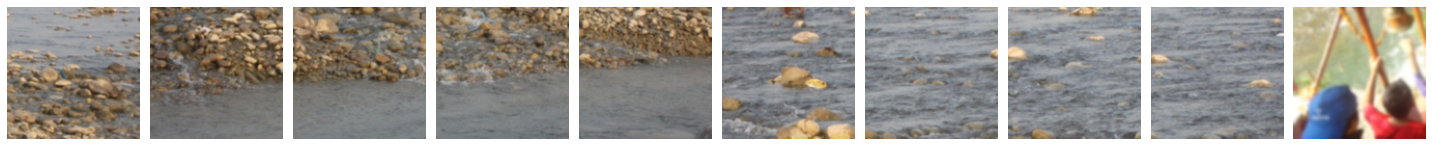

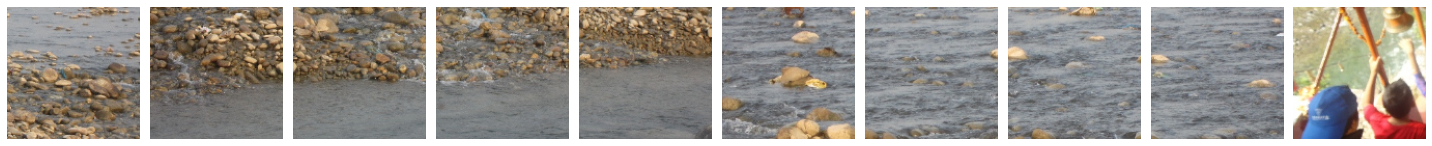

In [6]:
xx,yy=train[4]
plotImages(xx)
plotImages(yy)

In [5]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(128,128,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 64, 3)
   conv_block2 = conv_operation(conv_block1, 128, 3)
   conv_block3 = conv_operation(conv_block2, 256, 3)
   conv_block4 = conv_operation(conv_block3, 512, 3)
   
   conv_block5 = conv_operation(conv_block4, 512, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 512,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 256, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 128, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 64, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

#    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, final_deconv, name='dae')

In [6]:
model= deblurring_autoencoder()

In [ ]:
model.summary()

In [7]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [8]:
log_dir="logs\\fit\\"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
m_chk=ModelCheckpoint('deblur.h5',verbose=1,save_best_only=True,save_weights_only=True)
t_brd=TensorBoard(log_dir=log_dir,histogram_freq=1)
callbacks=[m_chk,t_brd]

In [10]:
model.fit(
    train,
    epochs=35,
    verbose=1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 312 steps
Epoch 1/35
312/312 [==============================] - 118s 378ms/step - loss: 0.0283 - mae: 0.1207
Epoch 2/35
312/312 [==============================] - 133s 426ms/step - loss: 0.0115 - mae: 0.0830
Epoch 3/35
312/312 [==============================] - 140s 450ms/step - loss: 0.0088 - mae: 0.0731
Epoch 4/35
312/312 [==============================] - 146s 468ms/step - loss: 0.0072 - mae: 0.0656
Epoch 5/35
312/312 [==============================] - 135s 434ms/step - loss: 0.0063 - mae: 0.0616
Epoch 6/35
312/312 [==============================] - 134s 428ms/step - loss: 0.0055 - mae: 0.0579
Epoch 7/35
312/312 [==============================] - 132s 425ms/step - loss: 0.0049 - mae: 0.0544
Epoch 8/35
312/312 [==============================] - 132s 423ms/step - loss: 0.0042 - mae: 0.0497
Epoch 9/35
312/312 [==============================] - 131s 421ms/step - loss: 0.0037 - mae: 0.0466
Epoch 10/35
312/312 [==============================] - 131s 419m

312/312 [==============================] - 129s 413ms/step - loss: 0.0017 - mae: 0.0296
Epoch 33/35
312/312 [==============================] - 129s 414ms/step - loss: 0.0016 - mae: 0.0288
Epoch 34/35
312/312 [==============================] - 129s 413ms/step - loss: 0.0015 - mae: 0.0275
Epoch 35/35
312/312 [==============================] - 129s 413ms/step - loss: 0.0016 - mae: 0.0281


In [14]:
%load_ext tensorboard
%tensorboard --logdir 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-09-27 22:19:16.742965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_

In [15]:
%reload_ext tensorboard

In [12]:
keras.models.save_model(
    model,'try4'
)

INFO:tensorflow:Assets written to: try4\assets
